In [1]:
############################### Explanation ###############################
# This is a code for plotting optimal strategy over different cost level. It is a combined code
# for conservative/confirmative/certainty bias with different parameters that can be set.
# It has the following sturcture:
#   - calculate the transition matrix of invesitgating state 1 and state 2,
#     the entries of the transition matrix are probability of prior -> posterior
#   - use dynamic programming to iterate until convergence of value function, goes as follows:
#       1. start with V0 = zeros()
#       2. calculate Vt (and V_stop, V_1, V_2) according to transition matrices t1, t2 and Vt-1
#       3. stop if error(Vt - V) is small
#   - figure out the optimal strategy (V==V_stop), (V==V_1), (V==V_2) and plot the graph
#   - repeat this for every cost level

In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set printing options
np.set_printoptions(threshold=1200)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',500)

# set label size
#plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
#plt.rcParams['axes.labelweight'] = 'bold'
#plt.rcParams['xtick.labelsize'] = 8
#plt.rcParams['ytick.labelsize'] = 8
#plt.rcParams['legend.fontsize'] = 10
#plt.rcParams['figure.titlesize'] = 12

In [3]:
# combined code for conservative/confirmative/certainty bias

# coefficients
alpha_1 = 1 # update in the direction of more likely
alpha_2 = 1 # update in the direction of less likely
accuracy1 = 0.25 # prob of reveal for 1
accuracy2 = 0.25 # prob of reveal for 2
cost_vector = [5,5*2**0.5,10,10*2**0.5,20,20*2**0.5,40,40*2**0.5,80] # cost for investigation
stop_cost = 0 # stop cost
reward = 1000 # reward for getting the right state
number = 1001 # number of grids
p_grid = np.linspace(0,1,number,endpoint=True) # probability grid

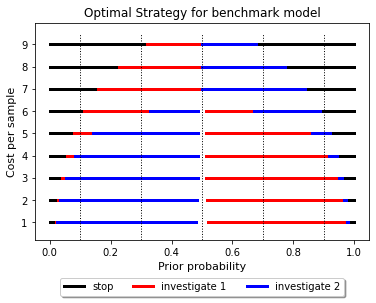

In [4]:
for cost in cost_vector:
    cost1 = cost # cost for investigating state 1 (symmetric)
    cost2 = cost # cost for investigating state 2 (symmetric)


    ############################### calculate the transition matrix ###############################
    t1 = np.zeros((number, number))
    t2 = np.zeros((number, number))


    # if investigate state 1
    for i in range(number):
        
        p = p_grid[i]
        prob_reveal = p*accuracy1
        posterior = p*(1-accuracy1)/(1 - prob_reveal)
        
        if p < 0.5: # update in the more likely direction
            posterior = alpha_1*posterior + (1-alpha_1)*p
        else: # update in the less likely direction
            posterior = alpha_2*posterior + (1-alpha_2)*p 
            
        no_signal = np.argmax(-(abs(p_grid - posterior))) # posterior for no-signal
        t1[i,number-1] = prob_reveal
        t1[i,no_signal] = 1 - prob_reveal
        if no_signal == (number-1):
            t1[i, no_signal] = 1


    # if investigate state 2
    for i in range(number):
        p = p_grid[i]
        prob_reveal = (1-p)*accuracy2
        posterior = p/(1 - prob_reveal)
        
        if p >= 0.5: # update in the more likely direction           
            posterior = alpha_1*posterior + (1-alpha_1)*p
        else: # update in the less likely direction
            posterior = alpha_2*posterior + (1-alpha_2)*p
        
        no_signal = np.argmax(-(abs(p_grid - posterior))) # posterior for no-signal
        t2[i,number-1] = prob_reveal 
        t2[i,no_signal] = 1 - prob_reveal
        if no_signal == (number-1):
            t2[i,no_signal] = 1


    ###################### dynamic programming for convergence of value function ######################
            
    # value function for stop
    V_stop = reward * np.maximum(p_grid, 1-p_grid) # vslue of stop
    V_stop[1:(number-1)] = V_stop[1:(number-1)] - stop_cost # minus stop cost for uncertainty bias


    # Dynamic Programming for convergence
    value = np.zeros(number) # initial v0
    error = 0.0005 # maximum error allowed
    limit = 100000000 # largest number of iterations
    diff = 1 # keep track of error
    count = 1 # keep track of number of iterations

    while diff > error: # iterate until reach the maximum error allowed
        V_1 = np.matmul(value,np.transpose(t1)) - cost1 # value of investigating state 1
        V_2 = np.matmul(value,np.transpose(t2)) - cost2 # value of investigating state 2
        V = np.maximum.reduce([V_stop,V_1,V_2]) # value of the optimal strategy
        diff = max(abs(V- value)) # difference between Vt and Vt-1
        count += 1
        if count > limit: # exceed maximum number of iterations
            break
        else:
            value = V # update Vt


    ############################ optimal strategy and plotting ############################
    
    action_stop = (V_stop == value)
    action_1 = (V_1 == value)
    action_2 = (V_2 == value)
    action_indifferent = np.logical_and(action_1+action_2 > 0, abs(V_1-V_2) < 0.03)
    
    # plot different investigation strtegy for different p-grid
    plt.plot(p_grid, (cost_vector.index(cost)+1)*np.ma.masked_where(action_stop==False, action_stop),'k', linewidth=3, label='stop' if cost == cost_vector[0] else '')
    plt.plot(p_grid, (cost_vector.index(cost)+1)*np.ma.masked_where(action_1==False, action_1),'r', linewidth=3, label='investigate 1' if cost == cost_vector[0] else '')
    plt.plot(p_grid, (cost_vector.index(cost)+1)*np.ma.masked_where(action_2==False, action_2),'b', linewidth=3, label='investigate 2' if cost == cost_vector[0] else '')
    plt.plot(p_grid, (cost_vector.index(cost)+1)*np.ma.masked_where(action_indifferent==False, action_indifferent),'w', linewidth=3)


plt.axis([-0.05, 1.05, 0.2, 9.975]) #axis range
plt.yticks(np.arange(1, 10, 1)) # add ticks
plt.xlabel('Prior probability') # add x-axis label
plt.ylabel('Cost per sample') # add y-axis label
lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3) # add legend


# plot title according to different model
if alpha_1==alpha_2==1 and stop_cost==0:
    plt.title('Optimal Strategy for benchmark model')
elif alpha_1 < 1 and alpha_2 < 1 and stop_cost==0:
    plt.title('Optimal Strategy for conservative update \nwith alpha1={alpha_1} and alpha2={alpha_2}'.format(alpha_1=alpha_1,alpha_2=alpha_2))
elif alpha_1 > 1 and alpha_2 < 1 and stop_cost==0:
    plt.title('Optimal Strategy for confirmative update \nwith alpha1={alpha_1} and alpha2={alpha_2}'.format(alpha_1=alpha_1,alpha_2=alpha_2))
elif stop_cost!=0:
    plt.title('Optimal Strategy for certainty bias \nwith stop cost={stop_cost}'.format(stop_cost=stop_cost))


# show the vertical lines in plot
for i in np.linspace(0.1,0.9,5,endpoint=True):
    plt.plot((i, i), (0, 9.5), 'k:', linewidth=1)

#plt.savefig('certainty bias', bbox_extra_artists=[lgd], bbox_inches='tight', dpi=300)